## Advanced Lane Finding Project

The goals / steps of this project are the following:

* (0) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* (1) Apply a distortion correction to raw images.
* (2) Use color transforms, gradients, etc., to create a thresholded binary image.
* (3) Apply a perspective transform to rectify binary image ("birds-eye view").
* (4) Detect lane pixels and fit to find the lane boundary.
* (5) Determine the curvature of the lane and vehicle position with respect to center.
* (6) Warp the detected lane boundaries back onto the original image.
* (7) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 0. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Save parameters


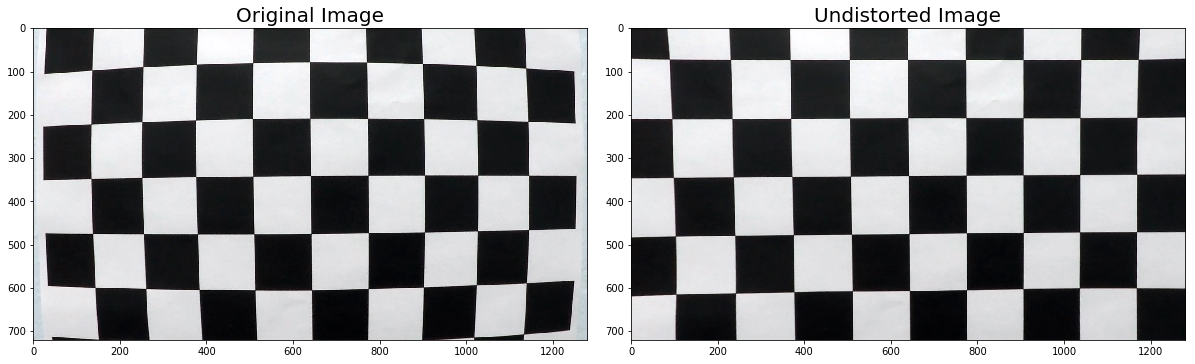

Undistorted Finish
Camera Calibration Finish


In [1]:
import pickle
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def camera_calibration():
    global img_size
    nx = 9  # TODO: enter the number of inside corners in x
    ny = 6  # TODO: enter the number of inside corners in y

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        img_size = img.shape
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            cv2.imshow('Img', img)
            cv2.waitKey(500)
    cv2.destroyAllWindows()

    # takes an image, object points, and image points performs the camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size[:2], None, None)

    if ret:  # Save camera calibration parameters
        dist_pickle = {'mtx': mtx, 'dist': dist, 'rvecs': rvecs, 'tvecs': tvecs}
        pickle.dump(dist_pickle, open('mtx_dist_pickle.p', 'wb'))
        print('Save parameters')

    # distortion-corrected image
    for img_name in os.listdir('test_images/'):
        image = cv2.imread('test_images/' + img_name)
        # Undistorting the image:
        img_undist = cv2.undistort(image, mtx, dist, None, mtx)
        cv2.imshow('img_name', img_undist)
        cv2.imwrite('test_images_result/' + img_name, img_undist)
        cv2.waitKey(1000)
    cv2.destroyAllWindows()

    # Display
    image = cv2.imread('camera_cal/calibration1.jpg')
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(img_undist)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    print("Undistorted Finish")


camera_calibration()
print('Camera Calibration Finish')

## 1. Apply a distortion correction to raw images.

Undistorted Finish


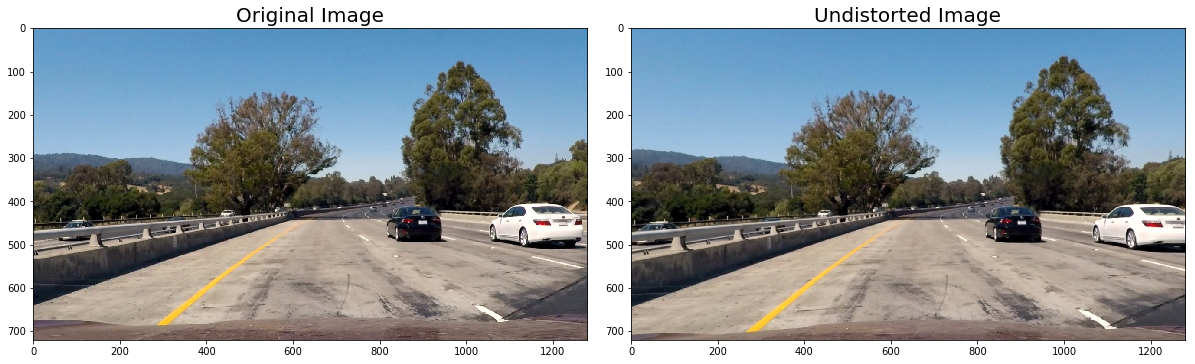

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# TODO 1. Provide an example of a distortion-corrected image.
mtx_dist__pickle = pickle.load(open("mtx_dist_pickle.p", "rb"))
mtx = mtx_dist__pickle["mtx"]
dist = mtx_dist__pickle["dist"]

# distortion-corrected image
image = mpimg.imread('test_images/test1.jpg')
# Undistorting the image:
img_undist = cv2.undistort(image, mtx, dist, None, mtx)
print("Undistorted Finish")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image.

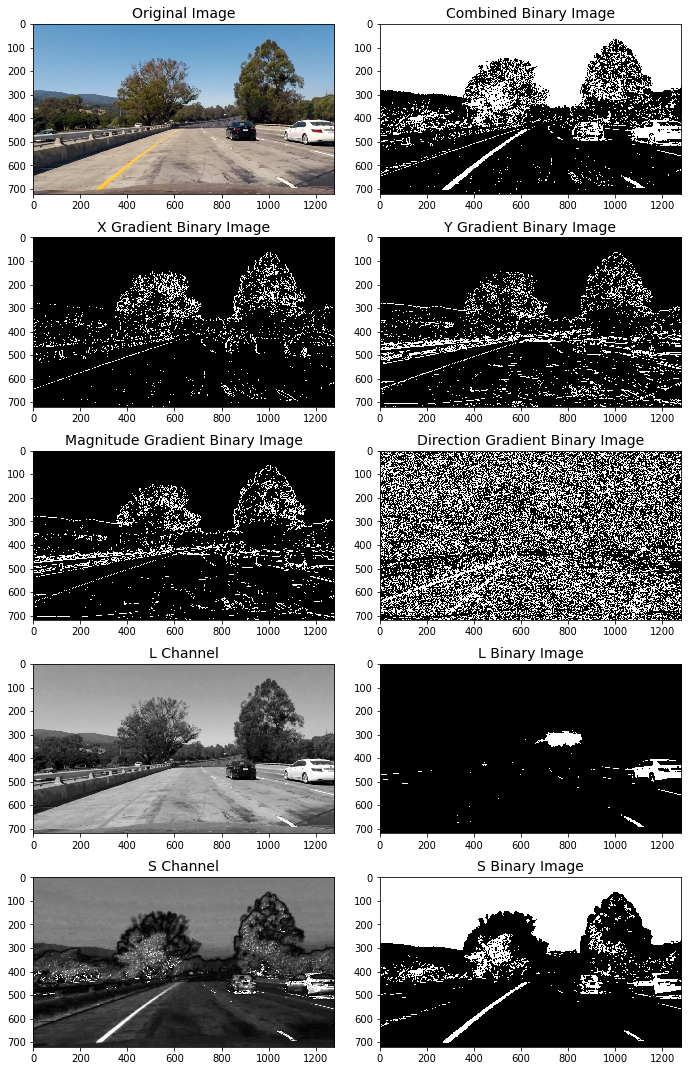

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# TODO 2. Use color transforms, gradients, etc., to create a thresholded binary image.
# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img_gray, orint='x', sobel_kernel=3, abs_thresh=(0, 255)):
    if 'x' == orint:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif 'y' == orint:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print('illegal direction!')
        return
    abs_sobel = np.absolute(sobel)
    scale_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    img_binary = np.zeros_like(img_gray)
    img_binary[(scale_sobel >= abs_thresh[0]) & (scale_sobel <= abs_thresh[1])] = 1
    return img_binary


# Define a function that applies Sobel x and y, then computes the
# magnitude of the gradient and applies a threshold
def mag_thresh(img_gray, sobel_kernel=3, mag_thresh=(0, 255)):
    xsobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ysobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(xsobel * xsobel + ysobel * ysobel)
    factor = np.max(mag_sobel)
    mag_sobel = (mag_sobel * 255 / factor).astype(np.uint8)
    img_binary = np.zeros_like(img_gray)
    img_binary[(mag_sobel >= mag_thresh[0]) & (mag_sobel <= mag_thresh[1])] = 1
    return img_binary


# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
def dir_thresh(img_gray, sobel_kernel=3, dir_thresh=(0, np.pi / 2)):
    xsobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ysobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dir_sobel = np.arctan2(np.absolute(ysobel), np.absolute(xsobel))
    img_binary = np.zeros_like(img_gray)
    img_binary[(dir_sobel >= dir_thresh[0]) & (dir_sobel <= dir_thresh[1])] = 1
    return img_binary


# Define a function that thresholds the channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_channel(img_origin, channel='h', thresh=(0, 255)):
    hls = cv2.cvtColor(img_origin, cv2.COLOR_RGB2HLS)
    if 'h' == channel:
        img_channel = hls[:, :, 0]
    elif 'l' == channel:
        img_channel = hls[:, :, 1]
    elif 's' == channel:
        img_channel = hls[:, :, 2]
    else:
        print('illegal image channel!')
        return
    # Threshold color channel
    img_binary = np.zeros_like(img_channel)
    img_binary[(img_channel > thresh[0]) & (img_channel <= thresh[1])] = 1
    return img_channel, img_binary


def combinations(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    xsobel_binary = abs_sobel_thresh(img_gray, 'x', 3, (20, 100))
    ysobel_binary = abs_sobel_thresh(img_gray, 'y', 3, (20, 120))
    mag_binary = mag_thresh(img_gray, 3, (30, 100))
    dir_binary = dir_thresh(img_gray, 15, (0.7, 1.3))
    l_channel, l_binary = hls_channel(img, 'l', (200, 255))
    s_channel, s_binary = hls_channel(img, 's', (90, 255))

    combined_binary = np.zeros_like(img_gray)
    combined_binary[(xsobel_binary == 1) |
                    (l_binary == 1) |
                    (s_binary == 1)] = 255

    # Save the binary image
    cv2.imwrite('test_images_result/image_binary.jpg', combined_binary)
    # Display images
    f, ax = plt.subplots(5, 2, figsize=(9, 16))
    f.tight_layout()
    ax[0, 0].imshow(img)
    ax[0, 0].set_title('Original Image', fontsize=14)
    ax[0, 1].imshow(combined_binary, cmap='gray')
    ax[0, 1].set_title('Combined Binary Image', fontsize=14)

    ax[1, 0].imshow(xsobel_binary, cmap='gray')
    ax[1, 0].set_title('X Gradient Binary Image', fontsize=14)
    ax[1, 1].imshow(ysobel_binary, cmap='gray')
    ax[1, 1].set_title('Y Gradient Binary Image', fontsize=14)

    ax[2, 0].imshow(mag_binary, cmap='gray')
    ax[2, 0].set_title('Magnitude Gradient Binary Image', fontsize=14)
    ax[2, 1].imshow(dir_binary, cmap='gray')
    ax[2, 1].set_title('Direction Gradient Binary Image', fontsize=14)

    ax[3, 0].imshow(l_channel, cmap='gray')
    ax[3, 0].set_title('L Channel', fontsize=14)
    ax[3, 1].imshow(l_binary, cmap='gray')
    ax[3, 1].set_title('L Binary Image', fontsize=14)

    ax[4, 0].imshow(s_channel, cmap='gray')
    ax[4, 0].set_title('S Channel', fontsize=14)
    ax[4, 1].imshow(s_binary, cmap='gray')
    ax[4, 1].set_title('S Binary Image', fontsize=14)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


image_undist = mpimg.imread('test_images_result/test1.jpg')
combinations(image_undist)


## 3. Apply a perspective transform to rectify binary image ("birds-eye view").

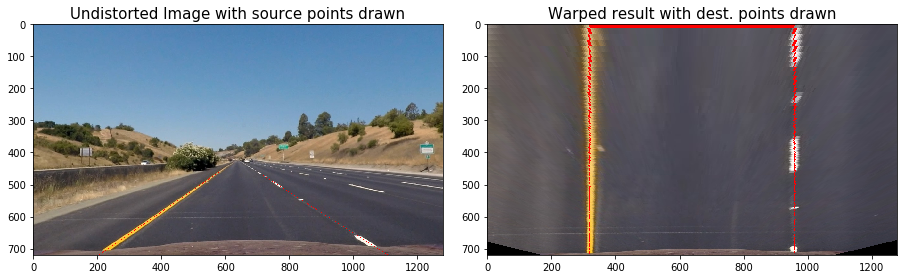

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# TODO 3. Apply a perspective transform to rectify binary image ("birds-eye view").
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped


def perspective_transform_show(img, src, dst):
    # Draw lines in original image
    cv2.line(img, tuple(src[0]), tuple(src[1]), color=(255, 0, 0), thickness=1)
    cv2.line(img, tuple(src[1]), tuple(src[2]), color=(255, 0, 0), thickness=1)
    cv2.line(img, tuple(src[2]), tuple(src[3]), color=(255, 0, 0), thickness=1)
    cv2.line(img, tuple(src[3]), tuple(src[0]), color=(255, 0, 0), thickness=1)
    # Perspective transform
    warped_img = warper(img, src, dst)
    # Display picture
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Undistorted Image with source points drawn', fontsize=15)
    ax2.imshow(warped_img, cmap='gray')
    ax2.set_title('Warped result with dest. points drawn', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


def perspective_transform_save(img, src, dst):
    # Perspective transform
    img_warped = warper(img, src, dst)
    cv2.imwrite('test_images_result/image_warped.jpg', img_warped)


image_show = mpimg.imread('test_images_result/straight_lines1.jpg')
image_binary = mpimg.imread('test_images_result/image_binary.jpg')
src_arr = np.float32([[582, 460], [205, 720], [1108, 720], [700, 460]])
dst_arr = np.float32([[320,   0], [320, 720], [960,  720], [960,   0]])
perspective_transform_show(image_show, src_arr, dst_arr)
perspective_transform_save(image_binary, src_arr, dst_arr)


## 4. Detect lane pixels and fit to find the lane boundary.

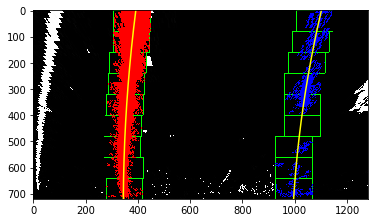

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def find_lane_pixels(img_warped):
    # Take a histogram of the bottom half of the image
    bottom_half = img_warped[img_warped.shape[0] // 2:, :]
    histogram = np.sum(bottom_half, axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img_warped, img_warped, img_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    left_base = np.argmax(histogram[0: midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])  # y-coordinate of nonzero points
    nonzerox = np.array(nonzero[1])  # x-coordinate of nonzero points

    # Current positions to be updated later for each window in nwindows
    leftx_current = left_base
    rightx_current = right_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_warped.shape[0] - (window + 1) * window_height
        win_y_high = img_warped.shape[0] - window * window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzerox >= win_xleft_low) &
                          (nonzerox <= win_xleft_high) &
                          (nonzeroy >= win_y_low) &
                          (nonzeroy <= win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) &
                           (nonzerox <= win_xright_high) &
                           (nonzeroy >= win_y_low) &
                           (nonzeroy <= win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window
        #  (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(img):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Visualization #
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    #
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


# Load our image
image = mpimg.imread('test_images_result/image_warped.jpg')
out_img = fit_polynomial(image)
plt.imshow(out_img)

## 5. Determine the curvature of the lane and vehicle position with respect to center.

In [6]:
# Load our image
image = mpimg.imread('test_images_result/image_warped.jpg')

# Find our lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_pixels(image)

# Fit a second order polynomial to each using `np.polyfit`
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty


# Calculate the radius of curvature based on pixel values
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2)) / (2*np.abs(left_fit[0]))
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2)) / (2*np.abs(right_fit[0]))
print('Pixel Left Curve: ', left_curverad)
print('Pixel Right Curve: ', right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

# Calculate the radius of curvature based on real world
y_eval = np.max(ploty)*ym_per_pix
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2)) / (2*np.abs(left_fit[0]))
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2)) / (2*np.abs(right_fit[0]))
print('Real Left Curve: ', left_curverad, 'm')
print('Real Right Curve: ', right_curverad, 'm')


# Calculate the offset from center
y_pos = image.shape[0]
base_left = left_fit[0] * y_pos * y_pos + left_fit[1] * y_pos + left_fit[2]
base_right = right_fit[0] * y_pos * y_pos + right_fit[1] * y_pos + right_fit[2]
car_pos = image.shape[0]/2
offset = ((base_right - base_left)/2 - car_pos) * xm_per_pix
print('Car Offset: ', offset)


Pixel Left Curve:  5880.163373988151
Pixel Right Curve:  4237.628319410508
Real Left Curve:  6012.06041437428 m
Real Right Curve:  4538.5867253991355 m
Car Offset:  -0.1823026055403203


## 6. Warp the detected lane boundaries back onto the original image.
## 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

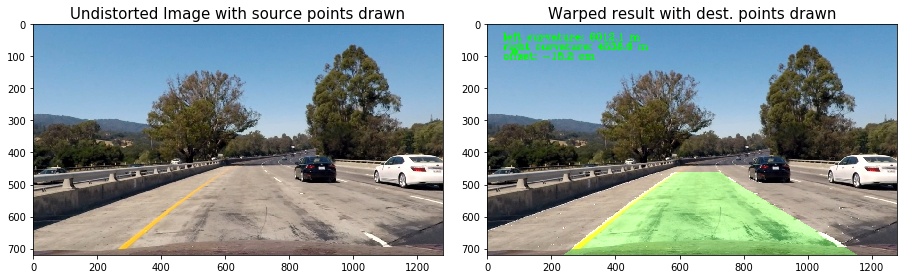

In [7]:
origin_img = mpimg.imread('test_images_result/test1.jpg')

left_pos = np.array([left_fitx, ploty]).T
right_pos = np.array([right_fitx, ploty]).T
right_pos = np.flipud(right_pos)
pos = np.vstack((left_pos, right_pos))

# new image
color_warp = np.dstack((image, image, image))
cv2.fillPoly(color_warp, np.int_([pos]), (0, 255, 0))

# transf
src = np.float32([[582, 460], [205, 720], [1108, 720], [700, 460]])
dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])
newwarp = warper(color_warp, dst, src)

result = cv2.addWeighted(origin_img, 1, newwarp, 0.3, 0)

# Add text
cv2.putText(result, 'left curvature: ' + str(round(left_curverad, 1)) + ' m',
            (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
cv2.putText(result, 'right curvature: ' + str(round(right_curverad, 1)) + ' m',
            (50, 80), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
cv2.putText(result, 'offset: ' + str(round(offset * 100., 1)) + ' cm',
            (50, 110), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout()
ax1.imshow(origin_img)
ax1.set_title('Origin Image', fontsize=15)
ax2.imshow(result)
ax2.set_title('Result Image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
